# Filtering dataframe for fertility analysis

The following filtering steps are according to NAV, apart from choice of breeds. Edits are performed on "fertilityDF_W.csv" i.e. after "BuildingDataframe.ipynb" & "FertilityTraits.ipynb" have been run
- Add 305d MY from raw data and check missing MY records (a756bc39, 6d38bc90)
- Keep only data from SH and NRDC
- Keep only lactation 1-8 
- Make parity 1, 2, >=3 
- Records within 150 days from data extraction are excluded from the data set 
- Only the first 10 inseminations are accepted for CR 
- Age at first calving: 550d - 1100d 
- CI maximum 2 years for cows
- CFS 20 - 230d
- FLS max 365d

Putting thresholds on classical fertility traits according to NAV or µ+-2SD of respective trait
- CFI: 20-230
- CLI: 20+217
- FLI: 0-365
- CI: 301-730
- GL: 260-302

Allow for minimum 5 records in HYS groups (of insemination date) to help convergence in analysis

In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from fpdf import FPDF

import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product

In [2]:
# LOAD DATA
df3 = pd.read_csv("../Data/CowData/fertilityDF_W.csv", low_memory=False)

In [3]:
# Crude data distribution
print(f"No. observations in fertilityDF_W.csv.csv: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in fertilityDF_W.csv: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in fertilityDF_W.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in fertilityDF_W.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in fertilityDF_W.csv: {test.shape}")

No. observations in fertilityDF_W.csv.csv: (7024, 67)
Double check no. pregnancy checks in fertilityDF_W.csv: (6909, 67)
No. ins without pregnancy checks: 115
No. inseminations in fertilityDF_W.csv: (4673, 67)
No. lactations in fertilityDF_W.csv: (2555, 67)
No. cows in fertilityDF_W.csv: (1516, 67)


Keep only herds with (MY_W) data

In [4]:
# Count number of inseminations in herds
ins_count = df3.groupby("FarmName_Pseudo")["InseminationDate"].count()
print(ins_count)

FarmName_Pseudo
5b581702     516
5c06d92d    2676
6d38bc90     255
a624fb9a     868
a756bc39     958
ad0a39f5    1461
f454e660     240
Name: InseminationDate, dtype: int64


In [5]:
# Count presence of HeatStress in the herds with issues with MY data
herds_to_keep = ['a756bc39', '6d38bc90']
df4 = df3[df3["FarmName_Pseudo"].isin(herds_to_keep)]

non_nan_count = df4['HeatStress'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df4['HeatStress'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")


Number of non-NaN values: 974
Number of NaN values: 249


In [6]:
# Check if herds with issues with MY recording in DelPro have raw data from cow database
MY = pd.read_csv("C:/Users/pagd0001/Desktop/Gigacow/Data/20241009/Gigacow-tools/Projects/HeatStressEvaluation/Data/CowData/Kok_LactationReturn240820.csv", low_memory=False, delimiter=";")
col_keep = ["BirthID", "CalvingNumber", "Milk_Kg"]
MY = MY[col_keep]
MY.rename(columns={"BirthID": "SE_Number", "CalvingNumber": "LactationNumber"}, inplace=True)
MY = MY.drop_duplicates(subset=["SE_Number", "LactationNumber", "Milk_Kg"])

In [7]:
MY

,SE_Number,LactationNumber,Milk_Kg
0,SE-ad0a39f5-1831,2,14493
1,SE-ad0a39f5-1831,1,11931
2,SE-ad0a39f5-1831,3,14284
3,SE-ad0a39f5-1833,1,11432
4,SE-ad0a39f5-1834,1,10792
...,...,...,...
17648,SE-169e580a-5611,1,10820
17649,SE-169e580a-5612,1,8658
17650,SE-169e580a-5616,1,10720
17651,SE-ad0a39f5-2171,1,8469


In [8]:
# Add 305d MY records to fertilityDF_W.csv
df3 = pd.merge(df3, MY, on=["SE_Number", "LactationNumber"], how="left")
df3.to_csv("../Data/CowData/fertilityDF_W_MY.csv", index=False)
df3

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,last_preg_check,CR10,date_extraction,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,False,NaN,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,True,NaN,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,False,0.0,2024-08-18,2024-03-21,NaN,733,NaN,10.0,1.0,NaN
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,False,0.0,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,True,0.0,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,SE-f454e660-0800,1.0,2023-12-30,2,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,False,NaN,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN
7020,SE-f454e660-0800,1.0,2024-02-08,1,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,True,NaN,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN
7021,SE-f454e660-0803,1.0,2023-12-07,1,DairyCross,f454e660,803.0,1732.0,2021-09-29,SE-458cc45c-7315,...,True,NaN,2024-08-18,2024-03-21,NaN,255,NaN,0.0,0.0,NaN
7022,SE-f454e660-0823,1.0,2024-03-26,1,SLB,f454e660,823.0,5352.0,2021-12-22,SE-344e5591-2011,...,True,NaN,2024-08-18,2024-03-21,NaN,145,NaN,0.0,0.0,NaN


In [9]:
# Count presence of 305d MY records in the herds with issues with MY data in DelPro
herds_to_keep = ['a756bc39', '6d38bc90']
df4 = df3[df3["FarmName_Pseudo"].isin(herds_to_keep)]

non_nan_count = df4['Milk_Kg'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df4['Milk_Kg'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")

Number of non-NaN values: 811
Number of NaN values: 412


In [ ]:
""" =========================================================================>>> These herds have data reported to the cow database and can be included!
# Remove herds with missing MY records (a756bc39, 6d38bc90)
# Herds to remove
herds_to_remove = ['a756bc39', '6d38bc90']
df3 = df3[~df3['FarmName_Pseudo'].isin(herds_to_remove)]
"""

In [10]:
print(f"No. observations in fertilityDF_W_MY.csv.csv: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in fertilityDF_W_MY.csv: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in fertilityDF_W_MY.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in fertilityDF_W_MY.csv: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in fertilityDF_W_MY.csv: {test.shape}")

No. observations in fertilityDF_W_MY.csv.csv: (7024, 68)
Double check no. pregnancy checks in fertilityDF_W_MY.csv: (6909, 68)
No. ins without pregnancy checks: 115
No. inseminations in fertilityDF_W_MY.csv: (4673, 68)
No. lactations in fertilityDF_W_MY.csv: (2555, 68)
No. cows in fertilityDF_W_MY.csv: (1516, 68)


In [11]:
# Make HYS of insemination
df = df3.copy()
df['InseminationDate'] = pd.to_datetime(df['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df['YearSeason'] = df['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df["HYS"] = df["FarmName_Pseudo"] + df["YearSeason"]
df 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,date_extraction,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,10.0,1.0,NaN,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,SE-f454e660-0800,1.0,2023-12-30,2,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN,202301,f454e660202301
7020,SE-f454e660-0800,1.0,2024-02-08,1,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN,202401,f454e660202401
7021,SE-f454e660-0803,1.0,2023-12-07,1,DairyCross,f454e660,803.0,1732.0,2021-09-29,SE-458cc45c-7315,...,2024-08-18,2024-03-21,NaN,255,NaN,0.0,0.0,NaN,202301,f454e660202301
7022,SE-f454e660-0823,1.0,2024-03-26,1,SLB,f454e660,823.0,5352.0,2021-12-22,SE-344e5591-2011,...,2024-08-18,2024-03-21,NaN,145,NaN,0.0,0.0,NaN,202402,f454e660202402


In [12]:
# Keep only one observation per ins
df = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])

# Make Parity 1-3
df = df.copy()
df["Parity"] = df["LactationNumber"]
df.loc[(df['LactationNumber'] >= 3), 'Parity'] = 3

In [13]:
# Ensure no missing values in the relevant columns
df = df.dropna(subset=["CR0", "HeatStress", "Parity", "Breed", "HYS", "SE_Number"])

# Convert relevant columns to categorical variables
df = df.copy()
df["HeatStress"] = df["HeatStress"].astype("category")
df["Parity"] = df["Parity"].astype("category")
df["Breed"] = df["Breed"].astype("category")
df["HYS"] = df["HYS"].astype("category")
df["SE_Number"] = df["SE_Number"].astype("category")

# Define the formula for the mixed model
formula = "CR0 ~ C(HeatStress) + C(Parity) + C(Breed)"

# Fit the mixed model with HYS and SE_Number as random effects
model = smf.mixedlm(
    formula, 
    df, 
    groups=df["HYS"]  # Top-level random effect
)

# Fit the model
result = model.fit()
print(result.summary())

# Extract fixed effect coefficients (for LS-means)
fixed_effects = result.fe_params
print("Fixed effects:\n", fixed_effects)

# Create all combinations of HeatStress, Parity, and Breed
heatstress_levels = df["HeatStress"].cat.categories
parity_levels = df["Parity"].cat.categories
breed_levels = df["Breed"].cat.categories

combinations = list(product(heatstress_levels, parity_levels, breed_levels))
prediction_df = pd.DataFrame(combinations, columns=["HeatStress", "Parity", "Breed"])

# Match fixed effects structure for predictions
prediction_df["HeatStress"] = prediction_df["HeatStress"].astype("category")
prediction_df["Parity"] = prediction_df["Parity"].astype("category")
prediction_df["Breed"] = prediction_df["Breed"].astype("category")

# Predict CR0 values for each combination
predictions = result.predict(exog=prediction_df)

# Add predictions (LS-means) to the DataFrame
prediction_df["Predicted_CR0"] = predictions

# Calculate LS-means: Average predicted CR0 for each combination of HeatStress, Parity, and Breed
ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()

# Print the LS-means
print("LS-means estimates:\n", ls_means)
ls_means.to_csv("CR_LSM.csv")

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     CR0       
No. Observations:      3342        Method:                 REML      
No. Groups:            69          Scale:                  0.2403    
Min. group size:       1           Log-Likelihood:         -2400.9153
Max. group size:       152         Converged:              No        
Mean group size:       48.4                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.368    0.115  3.192 0.001  0.142  0.594
C(HeatStress)[T.1.0]       -0.028    0.025 -1.130 0.259 -0.077  0.021
C(Parity)[T.2.0]           -0.090    0.022 -4.055 0.000 -0.133 -0.046
C(Parity)[T.3.0]           -0.132    0.020 -6.493 0.000 -0.172 -0.092
C(Breed)[T.DairyBeefCross]  0.275   

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 31.481757
  warnings.warn(msg, ConvergenceWarning)
c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Use

Data from SH and NRDC

In [14]:
# Keep only data from SH and NRDC
breeds_to_keep = ["NRDC", "SLB"]
df3 = df3[df3["Breed"].isin(breeds_to_keep)]

In [15]:
print(f"No. observations in file: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in file: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (5527, 68)
Double check no. pregnancy checks in file: (5419, 68)
No. ins without pregnancy checks: 108
No. inseminations in file: (3709, 68)
No. lactations in file: (2007, 68)
No. cows in file: (1213, 68)


In [16]:
# Make HYS of insemination
df = df3.copy()
df['InseminationDate'] = pd.to_datetime(df['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df['YearSeason'] = df['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df["HYS"] = df["FarmName_Pseudo"] + df["YearSeason"]
df 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,date_extraction,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,10.0,1.0,NaN,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,SE-f454e660-0797,1.0,2023-12-05,1,SLB,f454e660,797.0,4648.0,2021-08-11,SE-458cc45c-7315,...,2024-08-18,2024-03-21,NaN,257,NaN,0.0,0.0,NaN,202301,f454e660202301
7019,SE-f454e660-0800,1.0,2023-12-30,2,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN,202301,f454e660202301
7020,SE-f454e660-0800,1.0,2024-02-08,1,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,2024-08-18,2024-03-21,NaN,192,NaN,0.0,0.0,NaN,202401,f454e660202401
7022,SE-f454e660-0823,1.0,2024-03-26,1,SLB,f454e660,823.0,5352.0,2021-12-22,SE-344e5591-2011,...,2024-08-18,2024-03-21,NaN,145,NaN,0.0,0.0,NaN,202402,f454e660202402


In [17]:
# Keep only one observation per ins
df = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])

# Make Parity 1-3
df = df.copy()
df["Parity"] = df["LactationNumber"]
df.loc[(df['LactationNumber'] >= 3), 'Parity'] = 3

In [18]:
# Ensure no missing values in the relevant columns
df = df.dropna(subset=["CR0", "HeatStress", "Parity", "Breed", "HYS", "SE_Number"])

# Convert relevant columns to categorical variables
df = df.copy()
df["HeatStress"] = df["HeatStress"].astype("category")
df["Parity"] = df["Parity"].astype("category")
df["Breed"] = df["Breed"].astype("category")
df["HYS"] = df["HYS"].astype("category")
df["SE_Number"] = df["SE_Number"].astype("category")

# Define the formula for the mixed model
formula = "CR0 ~ C(HeatStress) + C(Parity) + C(Breed)"

# Fit the mixed model with HYS and SE_Number as random effects
model = smf.mixedlm(
    formula, 
    df, 
    groups=df["HYS"]  # Top-level random effect
)

# Fit the model
result = model.fit()
print(result.summary())

# Extract fixed effect coefficients (for LS-means)
fixed_effects = result.fe_params
print("Fixed effects:\n", fixed_effects)

# Create all combinations of HeatStress, Parity, and Breed
heatstress_levels = df["HeatStress"].cat.categories
parity_levels = df["Parity"].cat.categories
breed_levels = df["Breed"].cat.categories

combinations = list(product(heatstress_levels, parity_levels, breed_levels))
prediction_df = pd.DataFrame(combinations, columns=["HeatStress", "Parity", "Breed"])

# Match fixed effects structure for predictions
prediction_df["HeatStress"] = prediction_df["HeatStress"].astype("category")
prediction_df["Parity"] = prediction_df["Parity"].astype("category")
prediction_df["Breed"] = prediction_df["Breed"].astype("category")

# Predict CR0 values for each combination
predictions = result.predict(exog=prediction_df)

# Add predictions (LS-means) to the DataFrame
prediction_df["Predicted_CR0"] = predictions

# Calculate LS-means: Average predicted CR0 for each combination of HeatStress, Parity, and Breed
ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()

# Print the LS-means
print("LS-means estimates:\n", ls_means)
ls_means.to_csv("CR_LSM.csv")

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   CR0       
No. Observations:    2658      Method:               REML      
No. Groups:          68        Scale:                0.2403    
Min. group size:     1         Log-Likelihood:       -1903.1110
Max. group size:     123       Converged:            Yes       
Mean group size:     39.1                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.522    0.024 21.966 0.000  0.476  0.569
C(HeatStress)[T.1.0] -0.028    0.026 -1.070 0.284 -0.080  0.023
C(Parity)[T.2.0]     -0.092    0.024 -3.778 0.000 -0.140 -0.044
C(Parity)[T.3.0]     -0.135    0.023 -5.943 0.000 -0.179 -0.090
C(Breed)[T.SLB]      -0.000    0.021 -0.013 0.989 -0.042  0.042
Group Var             0.003    0.004                 

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\pagd0001\AppData\Local\Temp\ipykernel_11468\1741322142.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()


Allow for maximum lactation 1-8

In [19]:
# Distribution of lactations
check = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
value_counts = check['LactationNumber'].value_counts()
print(value_counts)

LactationNumber
1.0     720
2.0     555
3.0     368
4.0     207
5.0     102
6.0      36
7.0       9
8.0       6
9.0       2
10.0      2
Name: count, dtype: int64


In [20]:
# Keep only lactation 1-8
df3 = df3[df3["LactationNumber"] <= 8]

# No. lactations and cows in data
print(f"No. observations in file: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in file: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (5513, 68)
Double check no. pregnancy checks in file: (5405, 68)
No. ins without pregnancy checks: 108
No. inseminations in file: (3700, 68)
No. lactations in file: (2003, 68)
No. cows in file: (1212, 68)


In [21]:
# Make Parity 1-3
df3 = df3.copy()
df3["Parity"] = df3["LactationNumber"]
df3.loc[(df3['LactationNumber'] >= 3) & (df3['LactationNumber'] <= 8), 'Parity'] = 3

In [22]:
# Make HYS of insemination
df = df3.copy()
df['InseminationDate'] = pd.to_datetime(df['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df['YearSeason'] = df['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df["HYS"] = df["FarmName_Pseudo"] + df["YearSeason"]
df 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,10.0,1.0,NaN,3.0,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,SE-f454e660-0797,1.0,2023-12-05,1,SLB,f454e660,797.0,4648.0,2021-08-11,SE-458cc45c-7315,...,2024-03-21,NaN,257,NaN,0.0,0.0,NaN,1.0,202301,f454e660202301
7019,SE-f454e660-0800,1.0,2023-12-30,2,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,2024-03-21,NaN,192,NaN,0.0,0.0,NaN,1.0,202301,f454e660202301
7020,SE-f454e660-0800,1.0,2024-02-08,1,NRDC,f454e660,800.0,5059.0,2021-08-24,SE-72d9fe50-7855,...,2024-03-21,NaN,192,NaN,0.0,0.0,NaN,1.0,202401,f454e660202401
7022,SE-f454e660-0823,1.0,2024-03-26,1,SLB,f454e660,823.0,5352.0,2021-12-22,SE-344e5591-2011,...,2024-03-21,NaN,145,NaN,0.0,0.0,NaN,1.0,202402,f454e660202402


In [23]:
# Drop duplicates of inseminations
df = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])

In [24]:
# Ensure no missing values in the relevant columns
df = df.dropna(subset=["CR0", "HeatStress", "Parity", "Breed", "HYS", "SE_Number"])

# Convert relevant columns to categorical variables
df = df.copy()
df["HeatStress"] = df["HeatStress"].astype("category")
df["Parity"] = df["Parity"].astype("category")
df["Breed"] = df["Breed"].astype("category")
df["HYS"] = df["HYS"].astype("category")
df["SE_Number"] = df["SE_Number"].astype("category")

# Define the formula for the mixed model
formula = "CR0 ~ C(HeatStress) + C(Parity) + C(Breed)"

# Fit the mixed model with HYS and SE_Number as random effects
model = smf.mixedlm(
    formula, 
    df, 
    groups=df["HYS"]  # Top-level random effect
)

# Fit the model
result = model.fit()
print(result.summary())

# Extract fixed effect coefficients (for LS-means)
fixed_effects = result.fe_params
print("Fixed effects:\n", fixed_effects)

# Create all combinations of HeatStress, Parity, and Breed
heatstress_levels = df["HeatStress"].cat.categories
parity_levels = df["Parity"].cat.categories
breed_levels = df["Breed"].cat.categories

combinations = list(product(heatstress_levels, parity_levels, breed_levels))
prediction_df = pd.DataFrame(combinations, columns=["HeatStress", "Parity", "Breed"])

# Match fixed effects structure for predictions
prediction_df["HeatStress"] = prediction_df["HeatStress"].astype("category")
prediction_df["Parity"] = prediction_df["Parity"].astype("category")
prediction_df["Breed"] = prediction_df["Breed"].astype("category")

# Predict CR0 values for each combination
predictions = result.predict(exog=prediction_df)

# Add predictions (LS-means) to the DataFrame
prediction_df["Predicted_CR0"] = predictions

# Calculate LS-means: Average predicted CR0 for each combination of HeatStress, Parity, and Breed
ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()

# Print the LS-means
print("LS-means estimates:\n", ls_means)
ls_means.to_csv("CR_LSM.csv")

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   CR0       
No. Observations:    2652      Method:               REML      
No. Groups:          68        Scale:                0.2405    
Min. group size:     1         Log-Likelihood:       -1899.9926
Max. group size:     123       Converged:            Yes       
Mean group size:     39.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.524    0.024 22.012 0.000  0.478  0.571
C(HeatStress)[T.1.0] -0.027    0.026 -1.038 0.299 -0.079  0.024
C(Parity)[T.2.0]     -0.092    0.024 -3.772 0.000 -0.140 -0.044
C(Parity)[T.3.0]     -0.133    0.023 -5.831 0.000 -0.177 -0.088
C(Breed)[T.SLB]      -0.004    0.021 -0.163 0.870 -0.046  0.039
Group Var             0.003    0.004                 

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\pagd0001\AppData\Local\Temp\ipykernel_11468\1741322142.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()


Records within 150 days from data extraction are excluded from the data set (i.e. open records)

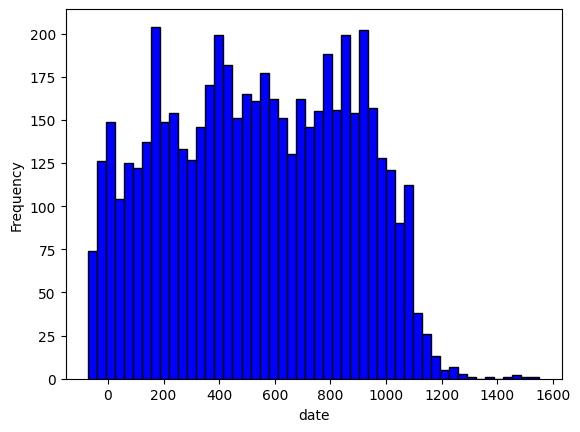

In [25]:
# Find open records
df3["extraction_limit"] = pd.to_datetime(df3["extraction_limit"])
df3["InseminationDate"] = pd.to_datetime(df3["InseminationDate"])

df3["open_rec"] = (df3["extraction_limit"] - df3["InseminationDate"]).dt.days

# Plot histogram
plt.hist(df3['open_rec'], bins=50, color='blue', edgecolor='black')
plt.xlabel('date')
plt.ylabel('Frequency')
plt.show()

In [26]:
non_nan_count = df3['open_rec'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df3['open_rec'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")

Number of non-NaN values: 5467
Number of NaN values: 46


In [27]:
df3 = df3[(df3["open_rec"] > 150)]

In [28]:
print(f"No. observations in file: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"Double check no. pregnancy checks in file: {test.shape}")
print(f'No. ins without pregnancy checks: {df3.shape[0] - test.shape[0]}')

test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df3.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (4649, 70)
Double check no. pregnancy checks in file: (4564, 70)
No. ins without pregnancy checks: 85
No. inseminations in file: (3011, 70)
No. lactations in file: (1649, 70)
No. cows in file: (1034, 70)


In [29]:
# Make HYS of insemination
df = df3.copy()
df['InseminationDate'] = pd.to_datetime(df['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df['YearSeason'] = df['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df["HYS"] = df["FarmName_Pseudo"] + df["YearSeason"]
df 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,10.0,1.0,NaN,3.0,624.0,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0,202303,f454e660202303
7004,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0,202303,f454e660202303
7005,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0,202303,f454e660202303
7006,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0,202303,f454e660202303


In [30]:
# Drop duplicates of inseminations
df = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])

In [31]:
# Ensure no missing values in the relevant columns
df = df.dropna(subset=["CR0", "HeatStress", "Parity", "Breed", "HYS", "SE_Number"])

# Convert relevant columns to categorical variables
df = df.copy()
df["HeatStress"] = df["HeatStress"].astype("category")
df["Parity"] = df["Parity"].astype("category")
df["Breed"] = df["Breed"].astype("category")
df["HYS"] = df["HYS"].astype("category")
df["SE_Number"] = df["SE_Number"].astype("category")

# Define the formula for the mixed model
formula = "CR0 ~ C(HeatStress) + C(Parity) + C(Breed)"

# Fit the mixed model with HYS and SE_Number as random effects
model = smf.mixedlm(
    formula, 
    df, 
    groups=df["HYS"]  # Top-level random effect
)

# Fit the model
result = model.fit()
print(result.summary())

# Extract fixed effect coefficients (for LS-means)
fixed_effects = result.fe_params
print("Fixed effects:\n", fixed_effects)

# Create all combinations of HeatStress, Parity, and Breed
heatstress_levels = df["HeatStress"].cat.categories
parity_levels = df["Parity"].cat.categories
breed_levels = df["Breed"].cat.categories

combinations = list(product(heatstress_levels, parity_levels, breed_levels))
prediction_df = pd.DataFrame(combinations, columns=["HeatStress", "Parity", "Breed"])

# Match fixed effects structure for predictions
prediction_df["HeatStress"] = prediction_df["HeatStress"].astype("category")
prediction_df["Parity"] = prediction_df["Parity"].astype("category")
prediction_df["Breed"] = prediction_df["Breed"].astype("category")

# Predict CR0 values for each combination
predictions = result.predict(exog=prediction_df)

# Add predictions (LS-means) to the DataFrame
prediction_df["Predicted_CR0"] = predictions

# Calculate LS-means: Average predicted CR0 for each combination of HeatStress, Parity, and Breed
ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()

# Print the LS-means
print("LS-means estimates:\n", ls_means)
ls_means.to_csv("CR_LSM.csv")

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   CR0       
No. Observations:    2054      Method:               REML      
No. Groups:          55        Scale:                0.2400    
Min. group size:     1         Log-Likelihood:       -1469.0517
Max. group size:     123       Converged:            Yes       
Mean group size:     37.3                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.526    0.027 19.759 0.000  0.473  0.578
C(HeatStress)[T.1.0] -0.038    0.027 -1.377 0.168 -0.091  0.016
C(Parity)[T.2.0]     -0.093    0.028 -3.387 0.001 -0.147 -0.039
C(Parity)[T.3.0]     -0.144    0.026 -5.563 0.000 -0.194 -0.093
C(Breed)[T.SLB]      -0.001    0.024 -0.038 0.970 -0.048  0.046
Group Var             0.002    0.003                 

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\pagd0001\AppData\Local\Temp\ipykernel_11468\1741322142.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()


Only keep first 10 ins

In [32]:
# Only the first 10 inseminations are accepted
# Distribution of NINS
value_counts = df3["NINS"].value_counts()
print(value_counts)

NINS
1     1506
2     1393
3      849
4      423
5      240
6      133
8       45
7       29
9       20
13      11
Name: count, dtype: int64


In [33]:
# Count ins
df4 = df3.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
df4

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,date_extraction,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,10.0,1.0,NaN,3.0,624.0
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-08-18,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0
12,SE-30dc5787-1389,5.0,2021-06-28,1,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,2024-08-18,2024-03-21,332.0,1147,NaN,NaN,NaN,11556.0,3.0,997.0
14,SE-30dc5787-1389,6.0,2022-05-27,3,NRDC,a624fb9a,1389.0,12769.0,2015-01-27,SE-2725311b-7324,...,2024-08-18,2024-03-21,379.0,749,NaN,0.0,0.0,11830.0,3.0,664.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,SE-f454e660-0785,1.0,2023-07-29,1,SLB,f454e660,785.0,10998.0,2021-05-28,SE-458cc45c-7429,...,2024-08-18,2024-03-21,390.0,386,0.0,9.0,1.0,10102.0,1.0,236.0
7001,SE-f454e660-0790,1.0,2023-07-16,4,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-08-18,2024-03-21,344.0,356,NaN,14.0,1.0,8175.0,1.0,249.0
7003,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-08-18,2024-03-21,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0
7005,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-08-18,2024-03-21,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0


In [34]:
df3["InseminationDate"] = pd.to_datetime(df3["InseminationDate"])

df4 = df4.copy()
df4['InseminationDate'] = pd.to_datetime(df4['InseminationDate'])

df4['InsCount'] = df4.groupby(['SE_Number', 'LactationNumber']).cumcount() + 1
col_keep = ["SE_Number", "LactationNumber", "InseminationDate", "InsCount"]
df4 = df4[col_keep]

df5 = pd.merge(df3, df4, on=["SE_Number", "LactationNumber", "InseminationDate"], how="left")
df5

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,extraction_limit,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0,1
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0,1
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,10.0,1.0,NaN,3.0,624.0,1
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0,2
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,2024-03-21,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4644,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-03-21,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0,2
4645,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-03-21,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0,2
4646,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-03-21,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0,3
4647,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,2024-03-21,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0,3


In [35]:
# Distribution of NINS 
value_counts = df5["InsCount"].value_counts()
print(value_counts)

df5.to_csv("test.csv", index=False)

InsCount
1     2410
2     1266
3      558
4      224
5      112
6       43
7       16
8       13
9        5
10       1
11       1
Name: count, dtype: int64


In [36]:
# The first 10 ins are accepted
# Sort by cow, lactation, and insemination_date
df5 = df5.sort_values(by=["SE_Number", "LactationNumber", "InseminationDate"])

# Identify the last insemination record within each group (cow, lactation) where InsCount == 11
last_ins11 = (
    df5[df5["InsCount"] == 11]
    .groupby(["SE_Number", "LactationNumber"])["InseminationDate"]
    .idxmax()
)

# Remove these rows from the DataFrame
df5 = df5.drop(last_ins11)

value_counts = df5["InsCount"].value_counts()
print(value_counts)

InsCount
1     2410
2     1266
3      558
4      224
5      112
6       43
7       16
8       13
9        5
10       1
Name: count, dtype: int64


Age at first calving: 550d - 1100d 

In [37]:
# Load raw data to get full calving history from cow database
dfkok = pd.read_csv("C:/Users/pagd0001/Desktop/Gigacow/Data/20241009/Gigacow-tools/Projects/HeatStressEvaluation/Data/CowData/Kok_Calving240820.csv", delimiter=";", low_memory=False)
col_keep = ["BirthID", "CalvingDate", "CalvingNumber"]
dfkok = dfkok[col_keep]
dfkok = dfkok.rename(columns={"BirthID": "SE_Number", "CalvingNumber": "LactationNumber"})
dfkok = dfkok.drop_duplicates(subset=["SE_Number", "LactationNumber"])
dfkok

,SE_Number,CalvingDate,LactationNumber
0,SE-6d38bc90-1383,2020-07-11,7
1,SE-6d38bc90-1383,2021-08-12,8
2,SE-6d38bc90-1384,2013-11-26,1
3,SE-6d38bc90-1384,2014-11-20,2
4,SE-6d38bc90-1384,2015-11-21,3
...,...,...,...
26472,SE-5b581702-1858,2021-01-10,1
26473,SE-5b581702-1858,2021-11-29,2
26474,SE-5b581702-1859,2021-02-11,1
26475,SE-5b581702-1859,2022-04-20,2


In [38]:
# Load raw data to get BirthDate
bd = pd.read_csv("C:/Users/pagd0001/Desktop/Gigacow/Data/20241009/Gigacow-tools/Projects/HeatStressEvaluation/Data/CowData/Kok_Lineage240821.csv", delimiter=";", low_memory=False)
col_keep = ["BirthID", "BirthDate"]
bd = bd[col_keep]
bd = bd.rename(columns={"BirthID": "SE_Number"})
bd = bd.drop_duplicates(subset=["SE_Number"])
bd


,SE_Number,BirthDate
0,SE-6d38bc90-1772,2014-05-13
1,SE-6d38bc90-1774,2014-05-16
2,SE-6d38bc90-1775,2014-05-16
3,SE-6d38bc90-1776,2014-05-18
4,SE-6d38bc90-1777,2014-05-27
...,...,...
24062,SE-5b581702-1838,2018-07-28
24063,SE-5b581702-1839,2018-07-29
24064,SE-5b581702-1840,2018-08-03
24065,SE-5b581702-1841,2018-08-13


In [39]:
# Combine
dfkok = pd.merge(dfkok, bd, on=["SE_Number"], how="left")

In [40]:
# Calculate age at first calving
dfkok = dfkok[dfkok["LactationNumber"] == 1]
dfkok = dfkok.copy()
dfkok["BirthDate"] = pd.to_datetime(dfkok["BirthDate"])
dfkok["CalvingDate"] = pd.to_datetime(dfkok["CalvingDate"])
dfkok["AgeFirstCalving"] = (dfkok["CalvingDate"] - dfkok["BirthDate"]).dt.days

col_keep = ["SE_Number", "AgeFirstCalving"]
dfkok = dfkok[col_keep]
dfkok

,SE_Number,AgeFirstCalving
2,SE-6d38bc90-1384,763
9,SE-6d38bc90-1385,754
13,SE-6d38bc90-1387,1068
17,SE-6d38bc90-1392,844
22,SE-6d38bc90-1393,708
...,...,...
23666,SE-5b581702-1854,797
23669,SE-5b581702-1855,824
23673,SE-5b581702-1856,862
23676,SE-5b581702-1858,784


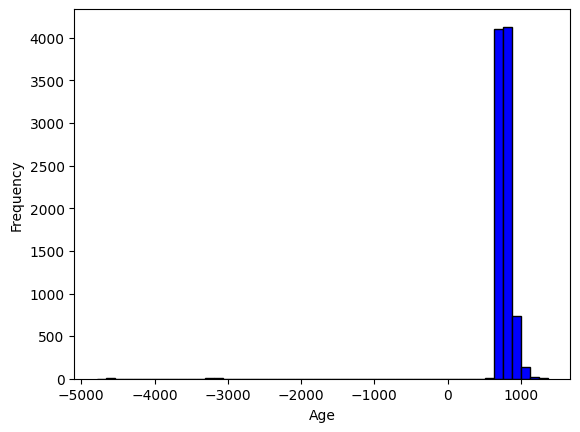

In [41]:
# Plot
plt.hist(dfkok['AgeFirstCalving'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [42]:
# Merge back onto current dataset
df6 = pd.merge(df5, dfkok, on=["SE_Number"], how="left")
df6

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,lact_length,extraction_to_last_ins,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount,AgeFirstCalving
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0,1,786
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,328.0,1097,NaN,NaN,NaN,10208.0,3.0,947.0,1,786
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,10.0,1.0,NaN,3.0,624.0,1,786
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0,2,786
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,733,NaN,30.0,1.0,NaN,3.0,583.0,2,786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0,2,701
4644,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,10.0,1.0,8175.0,1.0,227.0,2,701
4645,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0,3,701
4646,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,344.0,356,NaN,18.0,1.0,8175.0,1.0,206.0,3,701


In [43]:
non_nan_count = df6['AgeFirstCalving'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df6['AgeFirstCalving'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")

Number of non-NaN values: 4648
Number of NaN values: 0


In [44]:
# Filter age at first calving keeping only inseminations from cows with an age between 550 and 1100days old
df6 = df6[df6['AgeFirstCalving'].between(550, 1100)]

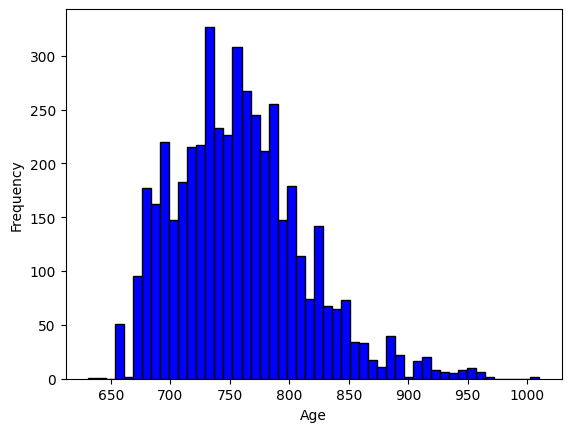

In [45]:
# Plot
plt.hist(df6['AgeFirstCalving'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [46]:
print(f"No. observations in file: {df6.shape}")

test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in file: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in file: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in file: {test.shape}")

No. observations in file: (4648, 72)
No. inseminations in file: (3010, 72)
No. lactations in file: (1649, 72)
No. cows in file: (1034, 72)


In [47]:
# Make HYS of insemination
df = df6.copy()
df['InseminationDate'] = pd.to_datetime(df['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df['YearSeason'] = df['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df["HYS"] = df["FarmName_Pseudo"] + df["YearSeason"]
df 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount,AgeFirstCalving,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,NaN,NaN,10208.0,3.0,947.0,1,786,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,NaN,NaN,10208.0,3.0,947.0,1,786,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,10.0,1.0,NaN,3.0,624.0,1,786,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,30.0,1.0,NaN,3.0,583.0,2,786,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,30.0,1.0,NaN,3.0,583.0,2,786,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,10.0,1.0,8175.0,1.0,227.0,2,701,202303,f454e660202303
4644,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,10.0,1.0,8175.0,1.0,227.0,2,701,202303,f454e660202303
4645,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,18.0,1.0,8175.0,1.0,206.0,3,701,202303,f454e660202303
4646,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,18.0,1.0,8175.0,1.0,206.0,3,701,202303,f454e660202303


In [48]:
# Drop duplicates of inseminations
df = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])

In [49]:
# Ensure no missing values in the relevant columns
df = df.dropna(subset=["CR0", "HeatStress", "Parity", "Breed", "HYS", "SE_Number"])

# Convert relevant columns to categorical variables
df = df.copy()
df["HeatStress"] = df["HeatStress"].astype("category")
df["Parity"] = df["Parity"].astype("category")
df["Breed"] = df["Breed"].astype("category")
df["HYS"] = df["HYS"].astype("category")
df["SE_Number"] = df["SE_Number"].astype("category")

# Define the formula for the mixed model
formula = "CR0 ~ C(HeatStress) + C(Parity) + C(Breed)"

# Fit the mixed model with HYS and SE_Number as random effects
model = smf.mixedlm(
    formula, 
    df, 
    groups=df["HYS"]  # Top-level random effect
)

# Fit the model
result = model.fit()
print(result.summary())

# Extract fixed effect coefficients (for LS-means)
fixed_effects = result.fe_params
print("Fixed effects:\n", fixed_effects)

# Create all combinations of HeatStress, Parity, and Breed
heatstress_levels = df["HeatStress"].cat.categories
parity_levels = df["Parity"].cat.categories
breed_levels = df["Breed"].cat.categories

combinations = list(product(heatstress_levels, parity_levels, breed_levels))
prediction_df = pd.DataFrame(combinations, columns=["HeatStress", "Parity", "Breed"])

# Match fixed effects structure for predictions
prediction_df["HeatStress"] = prediction_df["HeatStress"].astype("category")
prediction_df["Parity"] = prediction_df["Parity"].astype("category")
prediction_df["Breed"] = prediction_df["Breed"].astype("category")

# Predict CR0 values for each combination
predictions = result.predict(exog=prediction_df)

# Add predictions (LS-means) to the DataFrame
prediction_df["Predicted_CR0"] = predictions

# Calculate LS-means: Average predicted CR0 for each combination of HeatStress, Parity, and Breed
ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()

# Print the LS-means
print("LS-means estimates:\n", ls_means)
ls_means.to_csv("CR_LSM.csv")

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   CR0       
No. Observations:    2053      Method:               REML      
No. Groups:          55        Scale:                0.2401    
Min. group size:     1         Log-Likelihood:       -1468.5820
Max. group size:     123       Converged:            Yes       
Mean group size:     37.3                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.526    0.027 19.783 0.000  0.474  0.578
C(HeatStress)[T.1.0] -0.038    0.027 -1.399 0.162 -0.092  0.015
C(Parity)[T.2.0]     -0.093    0.028 -3.386 0.001 -0.147 -0.039
C(Parity)[T.3.0]     -0.143    0.026 -5.541 0.000 -0.194 -0.093
C(Breed)[T.SLB]      -0.001    0.024 -0.028 0.978 -0.048  0.046
Group Var             0.002    0.003                 

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\pagd0001\AppData\Local\Temp\ipykernel_11468\1741322142.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()


Thresholds for classical fertility traits in editing full material (insemination wise)
- CI maximum 2 years for cows
- CFS 20 - 230d
- FLS max 365d

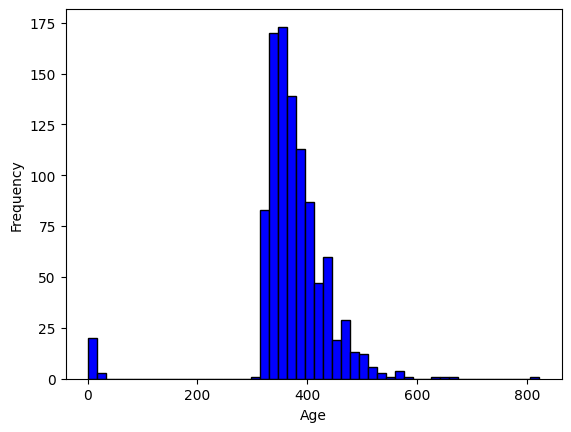

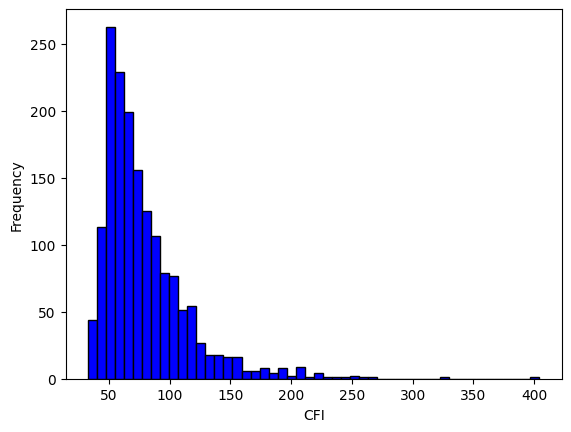

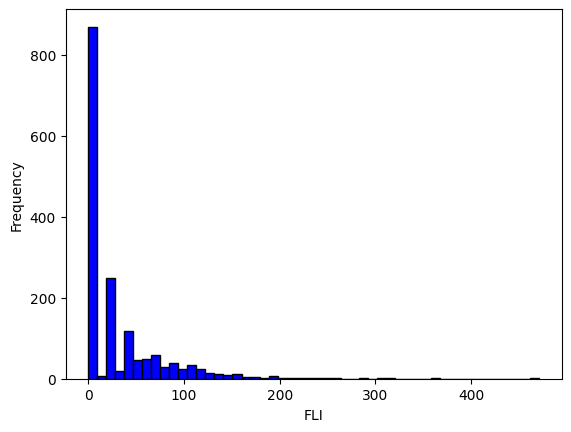

In [50]:
# Look at distribution of CI, CFI and FLI
df_fert = df6.drop_duplicates(subset=["SE_Number", "LactationNumber"])

plt.hist(df_fert['CI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_fert['CFI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('CFI')
plt.ylabel('Frequency')
plt.show()

plt.hist(df_fert['FLI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('FLI')
plt.ylabel('Frequency')
plt.show()

In [51]:
# Thresholds
# Filter for CI values less than or equal to 730 or NaN
df6 = df6[(df6["CI"] <= 730) | (df6["CI"].isna())]

# Filter for CFI values between 20 and 230 (inclusive) or NaN
df6 = df6[(df6["CFI"].between(20, 230, inclusive="both")) | (df6["CFI"].isna())]

# Filter for FLI values less than or equal to 365 or NaN
df6 = df6[(df6["FLI"] <= 365) | (df6["FLI"].isna())]

df6.to_csv("../data/CowData/fertilityDF_W_MY_filtered.csv", index=False)

In [52]:
print(f"No. observations in fertilityDF_W_MY_filtered.csv.csv: {df6.shape}")

test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. inseminations in filtered data: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. lactations in filtered data: {test.shape}")
test = df6.drop_duplicates(subset=["SE_Number"])
print(f"No. cows in filtered data: {test.shape}")

No. observations in fertilityDF_W_MY_filtered.csv.csv: (4620, 72)
No. inseminations in filtered data: (2990, 72)
No. lactations in filtered data: (1639, 72)
No. cows in filtered data: (1028, 72)


In [53]:
# Make HYS of insemination
df = df6.copy()
df['InseminationDate'] = pd.to_datetime(df['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df['YearSeason'] = df['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df["HYS"] = df["FarmName_Pseudo"] + df["YearSeason"]
df 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount,AgeFirstCalving,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,NaN,NaN,10208.0,3.0,947.0,1,786,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,NaN,NaN,10208.0,3.0,947.0,1,786,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,10.0,1.0,NaN,3.0,624.0,1,786,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,30.0,1.0,NaN,3.0,583.0,2,786,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,30.0,1.0,NaN,3.0,583.0,2,786,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,10.0,1.0,8175.0,1.0,227.0,2,701,202303,f454e660202303
4644,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,10.0,1.0,8175.0,1.0,227.0,2,701,202303,f454e660202303
4645,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,18.0,1.0,8175.0,1.0,206.0,3,701,202303,f454e660202303
4646,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,18.0,1.0,8175.0,1.0,206.0,3,701,202303,f454e660202303


In [54]:
# Drop duplicates of inseminations
df = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])

In [55]:
# Ensure no missing values in the relevant columns
df = df.dropna(subset=["CR0", "HeatStress", "Parity", "Breed", "HYS", "SE_Number"])

# Convert relevant columns to categorical variables
df = df.copy()
df["HeatStress"] = df["HeatStress"].astype("category")
df["Parity"] = df["Parity"].astype("category")
df["Breed"] = df["Breed"].astype("category")
df["HYS"] = df["HYS"].astype("category")
df["SE_Number"] = df["SE_Number"].astype("category")

# Define the formula for the mixed model
formula = "CR0 ~ C(HeatStress) + C(Parity) + C(Breed)"

# Fit the mixed model with HYS and SE_Number as random effects
model = smf.mixedlm(
    formula, 
    df, 
    groups=df["HYS"]  # Top-level random effect
)

# Fit the model
result = model.fit()
print(result.summary())

# Extract fixed effect coefficients (for LS-means)
fixed_effects = result.fe_params
print("Fixed effects:\n", fixed_effects)

# Create all combinations of HeatStress, Parity, and Breed
heatstress_levels = df["HeatStress"].cat.categories
parity_levels = df["Parity"].cat.categories
breed_levels = df["Breed"].cat.categories

combinations = list(product(heatstress_levels, parity_levels, breed_levels))
prediction_df = pd.DataFrame(combinations, columns=["HeatStress", "Parity", "Breed"])

# Match fixed effects structure for predictions
prediction_df["HeatStress"] = prediction_df["HeatStress"].astype("category")
prediction_df["Parity"] = prediction_df["Parity"].astype("category")
prediction_df["Breed"] = prediction_df["Breed"].astype("category")

# Predict CR0 values for each combination
predictions = result.predict(exog=prediction_df)

# Add predictions (LS-means) to the DataFrame
prediction_df["Predicted_CR0"] = predictions

# Calculate LS-means: Average predicted CR0 for each combination of HeatStress, Parity, and Breed
ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()

# Print the LS-means
print("LS-means estimates:\n", ls_means)
ls_means.to_csv("CR_LSM.csv")

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   CR0       
No. Observations:    2045      Method:               REML      
No. Groups:          55        Scale:                0.2401    
Min. group size:     1         Log-Likelihood:       -1462.6910
Max. group size:     123       Converged:            Yes       
Mean group size:     37.2                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.525    0.027 19.761 0.000  0.473  0.578
C(HeatStress)[T.1.0] -0.037    0.027 -1.359 0.174 -0.091  0.016
C(Parity)[T.2.0]     -0.091    0.028 -3.278 0.001 -0.145 -0.036
C(Parity)[T.3.0]     -0.145    0.026 -5.618 0.000 -0.196 -0.095
C(Breed)[T.SLB]      -0.001    0.024 -0.032 0.974 -0.048  0.046
Group Var             0.002    0.003                 

c:\Users\pagd0001\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\pagd0001\AppData\Local\Temp\ipykernel_11468\1741322142.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ls_means = prediction_df.groupby(["HeatStress", "Parity", "Breed"])["Predicted_CR0"].mean()


Minimum and maximum threshold on specific classical fertility traits
- i.e. if not within range, put to missing

In [56]:
# Load unfiltered data to check distribution
fert_df = pd.read_csv("../Data/CowData/fertilityDF_W_MY.csv", low_memory=False)
fert_df = fert_df.drop_duplicates(subset=["SE_Number", "LactationNumber"])

In [57]:
# Look at distributions
summary_stats = fert_df['GL'].describe()
percentiles = np.percentile(fert_df['GL'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

Descriptive Statistics:
 count    1260.000000
mean      272.807937
std        53.250092
min      -171.000000
25%       276.000000
50%       280.000000
75%       283.000000
max       632.000000
Name: GL, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [-79.28 269.   273.   287.   288.   295.  ]


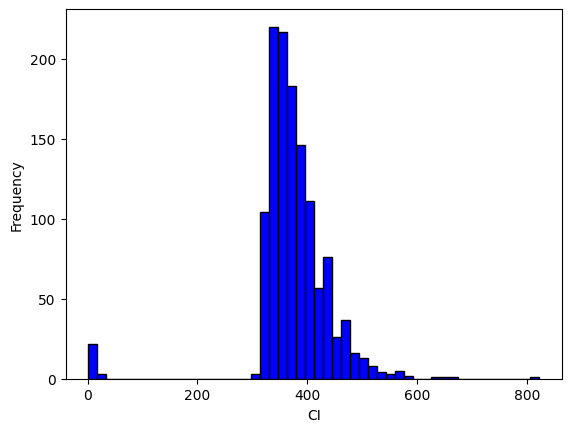

In [58]:
plt.hist(fert_df['CI'], bins=50, color='blue', edgecolor='black')
plt.xlabel('CI')
plt.ylabel('Frequency')
plt.show()

In [59]:
# Put thresholds on traits: Define the valid range and set outside this range to missing
df6 = pd.read_csv("../Data/CowData/fertilityDF_W_MY_filtered.csv", low_memory=False)

# CFI: 79 +- 35 => 20-230d according to NAV (min 32, max 404) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 37.  43.  48. 121. 146. 208.]
CFI_min = 20
CFI_max = 230

df6.loc[(df6["CFI"] < CFI_min) | (df6["CFI"] > CFI_max), "CFI"] = np.nan

# CLI: 107 +- 55 => 20-217 if CFI min 20 and FLI 0 then CLI also 20d, 217 = 107+(55*2)
#   (min 22, max 531) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 39.    48.    53.   181.   213.   293.46]
CLI_min = 20
CLI_max = 217

df6.loc[(df6["CLI"] < CLI_min) | (df6["CLI"] > CLI_max), "CLI"] = np.nan

# FLI: 28 +- 45 => 0-365d according to NAV (min 0, max 471) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [  0.     0.     0.    87.   115.   194.46]
FLI_min = 0
FLI_max = 365

df6.loc[(df6["FLI"] < FLI_min) | (df6["FLI"] > FLI_max), "FLI"] = np.nan

# CI: 373 +- 72 => 301-730d 301d according to 373-72, 730d according to NAV
#   (min 1, max 822) Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [  2.59 322.   329.   442.   472.   545.64] 
CI_min = 301
CI_max = 730

df6.loc[(df6["CI"] < CI_min) | (df6["CI"] > CI_max), "CI"] = np.nan

# GL: 260 - 302 according to NAV. Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [-79.28 269.   273.   287.   288.   295.  ]
GL_min = 260
GL_max = 302

df6.loc[(df6["GL"] < GL_min) | (df6["GL"] > GL_max), "GL"] = np.nan

In [60]:
# Double check distributions after handling outliers
summary_stats = df6['CFI'].describe()
percentiles = np.percentile(df6['CFI'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

Descriptive Statistics:
 count    4620.000000
mean       76.503030
std        31.542008
min        33.000000
25%        54.000000
50%        68.000000
75%        90.000000
max       226.000000
Name: CFI, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 37.   42.   47.  116.1 138.  192. ]


Allow for minimum 5 records in HYS groups (of insemination date)

In [61]:
# Make HYS of insemination
df6['InseminationDate'] = pd.to_datetime(df6['InseminationDate'])


# Function to determine the season based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


# Apply the function to create a 'YearSeason' variable
df6['YearSeason'] = df6['InseminationDate'].apply(lambda x: f"{x.year}0{get_season(x)}")

# Make HYS
df6["HYS"] = df6["FarmName_Pseudo"] + df6["YearSeason"]
df6 

,SE_Number,LactationNumber,InseminationDate,NINS_bw,Breed,FarmName_Pseudo,AnimalNumber,Del_Cow_Id,BirthDate,Father_SE_Number,...,CR11,HS_sum,HeatStress,Milk_Kg,Parity,open_rec,InsCount,AgeFirstCalving,YearSeason,HYS
0,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,NaN,NaN,10208.0,3.0,947.0,1,786,202103,a624fb9a202103
1,SE-064c0cec-1189,7.0,2021-08-17,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,NaN,NaN,10208.0,3.0,947.0,1,786,202103,a624fb9a202103
2,SE-064c0cec-1189,8.0,2022-07-06,2,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,10.0,1.0,NaN,3.0,624.0,1,786,202203,a624fb9a202203
3,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,30.0,1.0,NaN,3.0,583.0,2,786,202203,a624fb9a202203
4,SE-064c0cec-1189,8.0,2022-08-16,1,SLB,a624fb9a,5189.0,6131.0,2013-07-12,SE-507583a9-5088,...,NaN,30.0,1.0,NaN,3.0,583.0,2,786,202203,a624fb9a202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,10.0,1.0,8175.0,1.0,227.0,2,701,202303,f454e660202303
4616,SE-f454e660-0790,1.0,2023-08-07,3,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,10.0,1.0,8175.0,1.0,227.0,2,701,202303,f454e660202303
4617,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,18.0,1.0,8175.0,1.0,206.0,3,701,202303,f454e660202303
4618,SE-f454e660-0790,1.0,2023-08-28,2,SLB,f454e660,790.0,2867.0,2021-06-20,SE-1d7d190b-2832,...,NaN,18.0,1.0,8175.0,1.0,206.0,3,701,202303,f454e660202303


In [62]:
# Check distribution of HYS
print(df6["HYS"].value_counts())

HYS
ad0a39f5202104    207
ad0a39f5202201    184
5c06d92d202204    172
ad0a39f5202203    159
5c06d92d202303    155
                 ... 
ad0a39f5202001      2
5c06d92d202002      2
5c06d92d202003      2
5b581702202004      1
5c06d92d201901      1
Name: count, Length: 82, dtype: int64


In [63]:
# HYS requiring minimum 5 events, otherwise remove
# Count occurrences of each HYS group and filter to keep only 5 or above
hys_counts = df6["HYS"].value_counts()
valid_hys = hys_counts[hys_counts >= 5].index
df6 = df6[df6["HYS"].isin(valid_hys)]

print(df6["HYS"].value_counts())

HYS
ad0a39f5202104    207
ad0a39f5202201    184
5c06d92d202204    172
ad0a39f5202203    159
5c06d92d202303    155
                 ... 
5c06d92d202004      7
f454e660202304      6
f454e660202201      6
f454e660202103      6
ad0a39f5202004      5
Name: count, Length: 73, dtype: int64


Add threshold for 305d MY

In [69]:
# Occurrence of MY data
non_nan_count = df6['Milk_Kg'].notna().sum()
print(f"Number of non-NaN values: {non_nan_count}")

is_nan_count = df6['Milk_Kg'].isna().sum()
print(f"Number of NaN values: {is_nan_count}")

Number of non-NaN values: 4207
Number of NaN values: 391


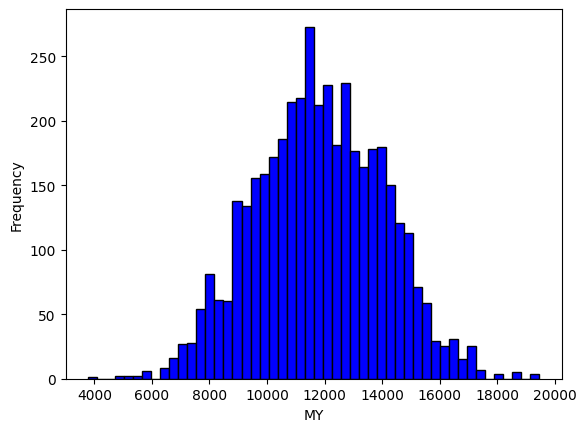

Descriptive Statistics:
 count     4207.000000
mean     11825.226290
std       2215.234104
min       3786.000000
25%      10272.000000
50%      11762.000000
75%      13459.500000
max      19456.000000
Name: Milk_Kg, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 6981.   8131.5  8954.  14673.4 15370.  16949. ]


In [70]:
# Plot MY
plt.hist(df6['Milk_Kg'], bins=50, color='blue', edgecolor='black')
plt.xlabel('MY')
plt.ylabel('Frequency')
plt.show()

# Look at distribution
summary_stats = df6['Milk_Kg'].describe()
percentiles = np.percentile(df6['Milk_Kg'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

In [71]:
# µ: 11,825. SD: 2215 => Thresholds: 7,395 - 16,255
MY_min = 7395
MY_max = 16255

df6.loc[(df6["Milk_Kg"] < MY_min) | (df6["Milk_Kg"] > MY_max), "Milk_Kg"] = np.nan

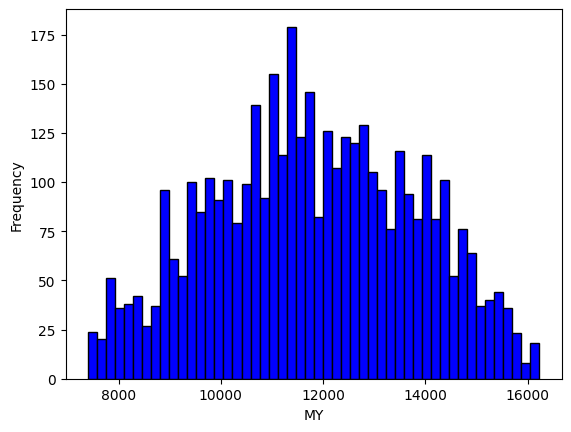

In [72]:
plt.hist(df6['Milk_Kg'], bins=50, color='blue', edgecolor='black')
plt.xlabel('MY')
plt.ylabel('Frequency')
plt.show()

Save filtered dataset

In [73]:
# Save filtered data
df6.to_csv("../Data/fertilityDF_W_MY_filtered.csv", index=False)

# Descriptive statistics - filtered data

In [74]:
# MILKING RECORDS
df_lact = pd.read_csv("../Data/fertilityDF_W_MY_filtered.csv", low_memory=False)

count_my_rec = df_lact.groupby(["Parity"])["InseminationDate"].count().reset_index()
print(f"No. of insemination records divided over parities: \n", count_my_rec.to_string(index=False))

count_my_rec = df_lact.groupby(["Parity", "Breed"])["InseminationDate"].count().reset_index()
print(f"No. of insemination records divided over parities and breeds: \n", count_my_rec.to_string(index=False))

# By parity
for_my_rec5 = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of parities in file: {for_my_rec5.shape}")

count_my_rec = for_my_rec5.groupby(["Breed"])["SE_Number"].count().reset_index()
print(f"No. of lactations from NRDC and SH: \n", count_my_rec.to_string(index=False))  

count_my_rec = for_my_rec5.groupby(["Parity", "Breed"])["SE_Number"].count().reset_index()
print(f"No. of cows within breed and parity: \n", count_my_rec.to_string(index=False))

# By cows
for_my_rec4 = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in file: {for_my_rec4.shape}") 

for_my_rec5 = for_my_rec4.drop_duplicates(subset=["SE_Number"])
count_my_rec = for_my_rec5.groupby(["Breed"])["SE_Number"].count().reset_index()
print(f"No. of cows from NRDC, SH: \n", count_my_rec.to_string(index=False))

# Herd info
df_lact = pd.read_csv("../Data/fertilityDF_W_MY_filtered.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["FarmName_Pseudo"])
col_keep = ["FarmName_Pseudo"]
df_lact = df_lact[col_keep]
print(df_lact.shape)
print(f"Herds in filtered data: \n", df_lact.to_string(index=False))

No. of insemination records divided over parities: 
  Parity  InseminationDate
    1.0              1680
    2.0              1265
    3.0              1653
No. of insemination records divided over parities and breeds: 
  Parity Breed  InseminationDate
    1.0  NRDC               565
    1.0   SLB              1115
    2.0  NRDC               416
    2.0   SLB               849
    3.0  NRDC               525
    3.0   SLB              1128
No. of parities in file: (1638, 74)
No. of lactations from NRDC and SH: 
 Breed  SE_Number
 NRDC        558
  SLB       1080
No. of cows within breed and parity: 
  Parity Breed  SE_Number
    1.0  NRDC        203
    1.0   SLB        385
    2.0  NRDC        157
    2.0   SLB        301
    3.0  NRDC        198
    3.0   SLB        394
No. of cows in file: (1028, 74)
No. of cows from NRDC, SH: 
 Breed  SE_Number
 NRDC        365
  SLB        663
(7, 1)
Herds in filtered data: 
 FarmName_Pseudo
       a624fb9a
       5b581702
       5c06d92d
       